# Taylor Swift Creative Evolution Over Eras

**Objective:** Use Spotify audio features and unsupervised learning to identify distinct “sonic clusters” across Taylor Swift’s catalog and visualize how these clusters shift over time.

**Deliverables:** Clean dataset of tracks + audio features, PCA visualization, clustering results, cluster interpretation, and a timeline of sound shifts by release year.

# Setup


In [94]:
!pip -q install spotipy

# Imports

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify API Authentication

Authenticate with Spotify’s Web API using the Client Credentials flow to access artist, album, track, and audio feature data.

In [96]:
import os
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

# Data Loading and Initial Inspection

In [97]:
df = pd.read_csv("taylor_swift_spotify.csv")
df.head()

,Unnamed: 0,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,0,Fortnight (feat. Post Malone),THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,1,6dODwocEuGzHAavXqTbwHv,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,0.000015,0.0961,-10.976,0.0308,192.004,0.281,82,228965
1,1,The Tortured Poets Department,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,2,4PdLaGZubp4lghChqp8erB,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.000000,0.1260,-8.441,0.0255,110.259,0.292,79,293048
2,2,My Boy Only Breaks His Favorite Toys,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,3,7uGYWMwRy24dm7RUDDhUlD,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.000000,0.3020,-7.362,0.0269,97.073,0.481,80,203801
3,3,Down Bad,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,4,1kbEbBdEgQdQeLXCJh28pJ,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,0.000001,0.0946,-10.412,0.0748,159.707,0.168,82,261228
4,4,"So Long, London",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,5,7wAkQFShJ27V8362MqevQr,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.002640,0.0816,-11.388,0.3220,160.218,0.248,80,262974


# Discography Overview

An overview of Taylor Swift's discography represented in the dataset, including albums, release years, and track counts.

In [98]:
df["album"].value_counts()

,count
album,
reputation Stadium Tour Surprise Song Playlist,46
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition],34
THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,31
Red (Taylor's Version),30
Fearless (Taylor's Version),26
Midnights (The Til Dawn Edition),23
Speak Now (Taylor's Version),22
Red (Deluxe Edition),22
1989 (Taylor's Version) [Deluxe],22


# Audio Feature Description

Spotify audio features quantify musical characteristics such as rhythm, energy, and timbral qualities. These features form the basis of the unsupervised learning analysis.

# Data Cleaning & Feature Engineering

In [99]:
# check for duplicates
df.duplicated().sum()

np.int64(0)

In [100]:
# check missing values
df.isnull().sum()

,0
Unnamed: 0,0
name,0
album,0
release_date,0
track_number,0
id,0
uri,0
acousticness,0
danceability,0
energy,0


In [101]:
# drop unnecessary index column
df = df.drop(columns=["Unnamed: 0"])

df.head()

,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Fortnight (feat. Post Malone),THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,1,6dODwocEuGzHAavXqTbwHv,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,0.000015,0.0961,-10.976,0.0308,192.004,0.281,82,228965
1,The Tortured Poets Department,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,2,4PdLaGZubp4lghChqp8erB,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.000000,0.1260,-8.441,0.0255,110.259,0.292,79,293048
2,My Boy Only Breaks His Favorite Toys,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,3,7uGYWMwRy24dm7RUDDhUlD,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.000000,0.3020,-7.362,0.0269,97.073,0.481,80,203801
3,Down Bad,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,4,1kbEbBdEgQdQeLXCJh28pJ,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,0.000001,0.0946,-10.412,0.0748,159.707,0.168,82,261228
4,"So Long, London",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024-04-19,5,7wAkQFShJ27V8362MqevQr,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.002640,0.0816,-11.388,0.3220,160.218,0.248,80,262974


In [102]:
# create release year feature
df["release_date"] = pd.to_datetime(df["release_date"])
df["release_year"] = df["release_date"].dt.year

df[["name", "album", "release_year"]].head()

,name,album,release_year
0,Fortnight (feat. Post Malone),THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024
1,The Tortured Poets Department,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024
2,My Boy Only Breaks His Favorite Toys,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024
3,Down Bad,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024
4,"So Long, London",THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,2024


In [103]:
# add audio features only
audio_features = ["danceability",
    "energy",
    "valence",
    "acousticness",
    "instrumentalness",
    "liveness",
    "speechiness",
    "tempo",
    "loudness"]

x = df[audio_features]
x.head()

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness
0,0.504,0.386,0.281,0.5020,0.000015,0.0961,0.0308,192.004,-10.976
1,0.604,0.428,0.292,0.0483,0.000000,0.1260,0.0255,110.259,-8.441
2,0.596,0.563,0.481,0.1370,0.000000,0.3020,0.0269,97.073,-7.362
3,0.541,0.366,0.168,0.5600,0.000001,0.0946,0.0748,159.707,-10.412
4,0.423,0.533,0.248,0.7300,0.002640,0.0816,0.3220,160.218,-11.388


In [104]:
# scale features

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# check
print(x_scaled.mean(axis=0))
print(x_scaled.std(axis=0))

[-5.49388713e-16  5.98223266e-16 -7.32518284e-17 -4.88345523e-17
 -2.44172761e-17  6.10431904e-17 -2.44172761e-17  3.83809059e-16
 -2.68590038e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Exploratory Data Analysis

Understand how Taylor Swift’s musical characteristics vary across songs, albums, and time, and identify patterns that may reflect creative evolution.

In [105]:
df.columns

Index(['name', 'album', 'release_date', 'track_number', 'id', 'uri',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity',
       'duration_ms', 'release_year'],
      dtype='object')

In [106]:
df[audio_features].describe()

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,0.580804,0.565832,0.391000,0.333185,0.003393,0.161130,0.056475,122.398954,-7.661986
std,0.114553,0.191102,0.195829,0.327171,0.027821,0.136563,0.070859,30.408485,2.904653
min,0.175000,0.118000,0.038400,0.000182,0.000000,0.033500,0.023100,68.097000,-17.932000
25%,0.515000,0.418000,0.230000,0.037325,0.000000,0.096525,0.030300,96.888000,-9.400750
50%,0.593500,0.571000,0.374000,0.184500,0.000002,0.114500,0.037600,119.054500,-7.352500
75%,0.653000,0.719000,0.522500,0.660000,0.000058,0.161000,0.054800,143.937250,-5.494750
max,0.897000,0.948000,0.943000,0.971000,0.333000,0.931000,0.912000,208.918000,-1.927000


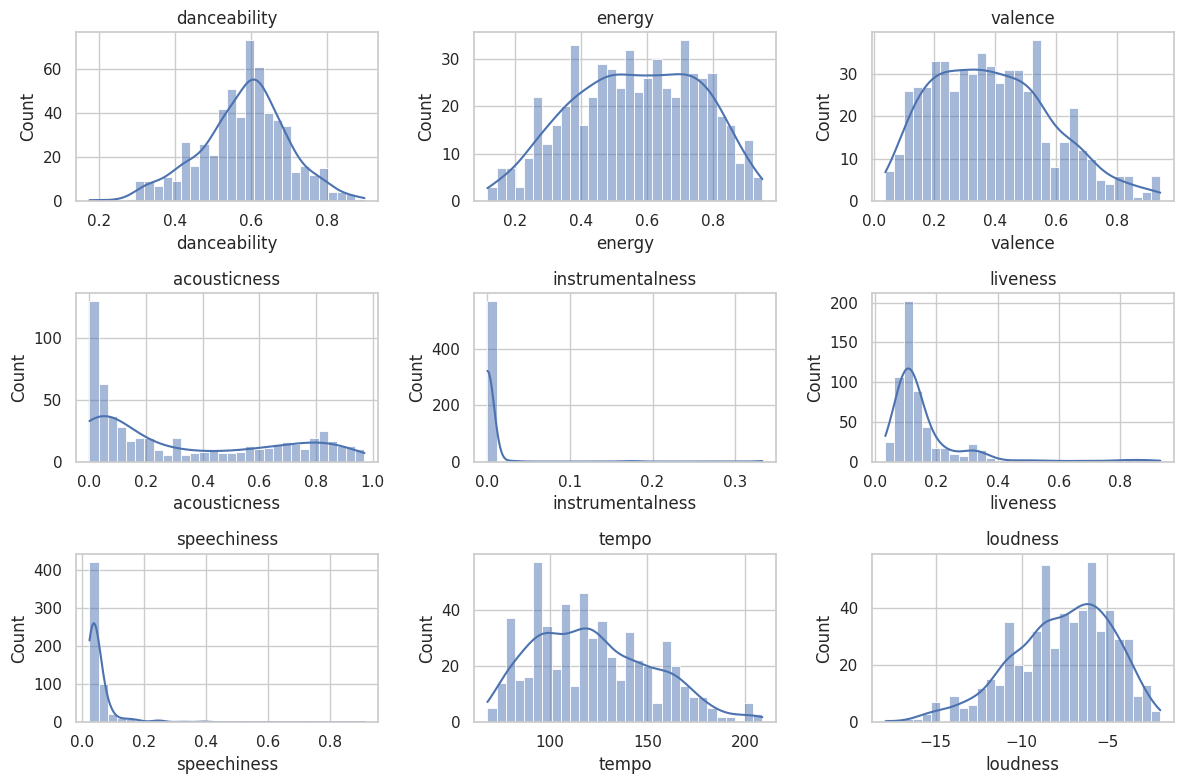

In [107]:
# distribution plots

plt.figure(figsize=(12, 8))

for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(feature)

plt.tight_layout()
plt.show()

In [108]:
# correlation matrix

corr = df[audio_features].corr()
corr

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness
danceability,1.000000,0.034833,0.303885,-0.178000,-0.070607,-0.139451,0.167959,-0.229525,0.016570
energy,0.034833,1.000000,0.487221,-0.711983,-0.081544,0.157008,-0.070511,0.175123,0.794626
valence,0.303885,0.487221,1.000000,-0.214348,-0.069740,-0.061147,0.050848,0.102885,0.357034
acousticness,-0.178000,-0.711983,-0.214348,1.000000,0.143078,-0.137689,0.047488,-0.064001,-0.725913
instrumentalness,-0.070607,-0.081544,-0.069740,0.143078,1.000000,-0.042495,-0.026335,-0.005492,-0.194656
liveness,-0.139451,0.157008,-0.061147,-0.137689,-0.042495,1.000000,0.083958,-0.019967,0.123641
speechiness,0.167959,-0.070511,0.050848,0.047488,-0.026335,0.083958,1.000000,0.049339,-0.243075
tempo,-0.229525,0.175123,0.102885,-0.064001,-0.005492,-0.019967,0.049339,1.000000,0.117701
loudness,0.016570,0.794626,0.357034,-0.725913,-0.194656,0.123641,-0.243075,0.117701,1.000000


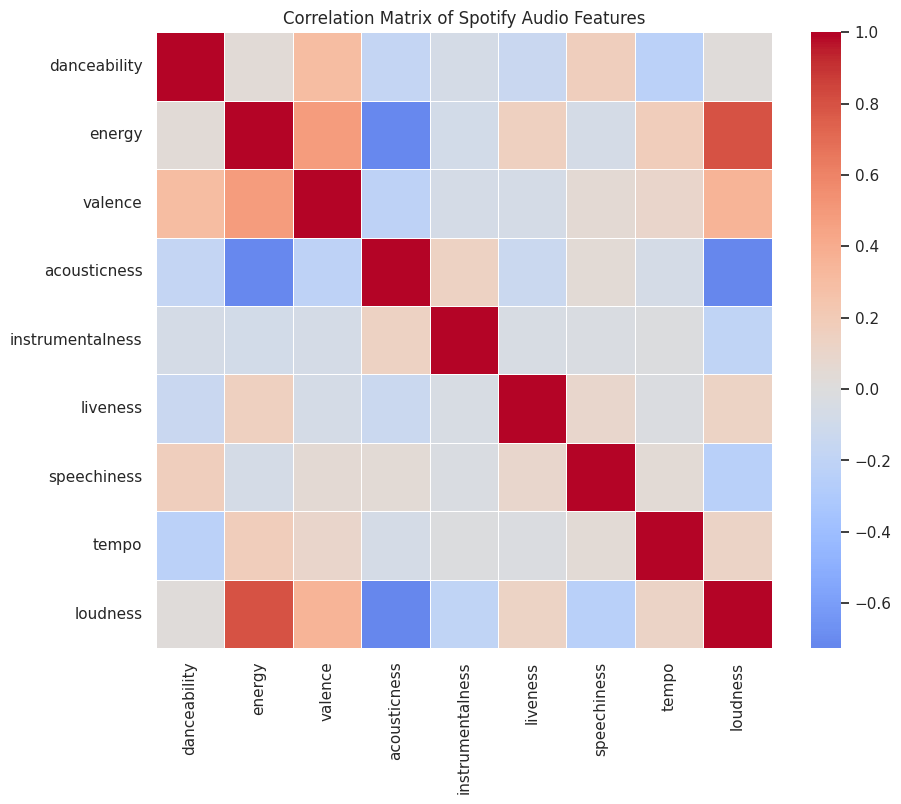

In [109]:
# correlation heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix of Spotify Audio Features")
plt.show()

### Pairwise Feature Relationships
While the correlation matrix summarizes linear relationships numerically,
pairwise plots provide a visual view of how key audio features interact.
This helps identify non-linear patterns, clusters, and stylistic patterns
that may not be fully captured by correlation coefficients alone.

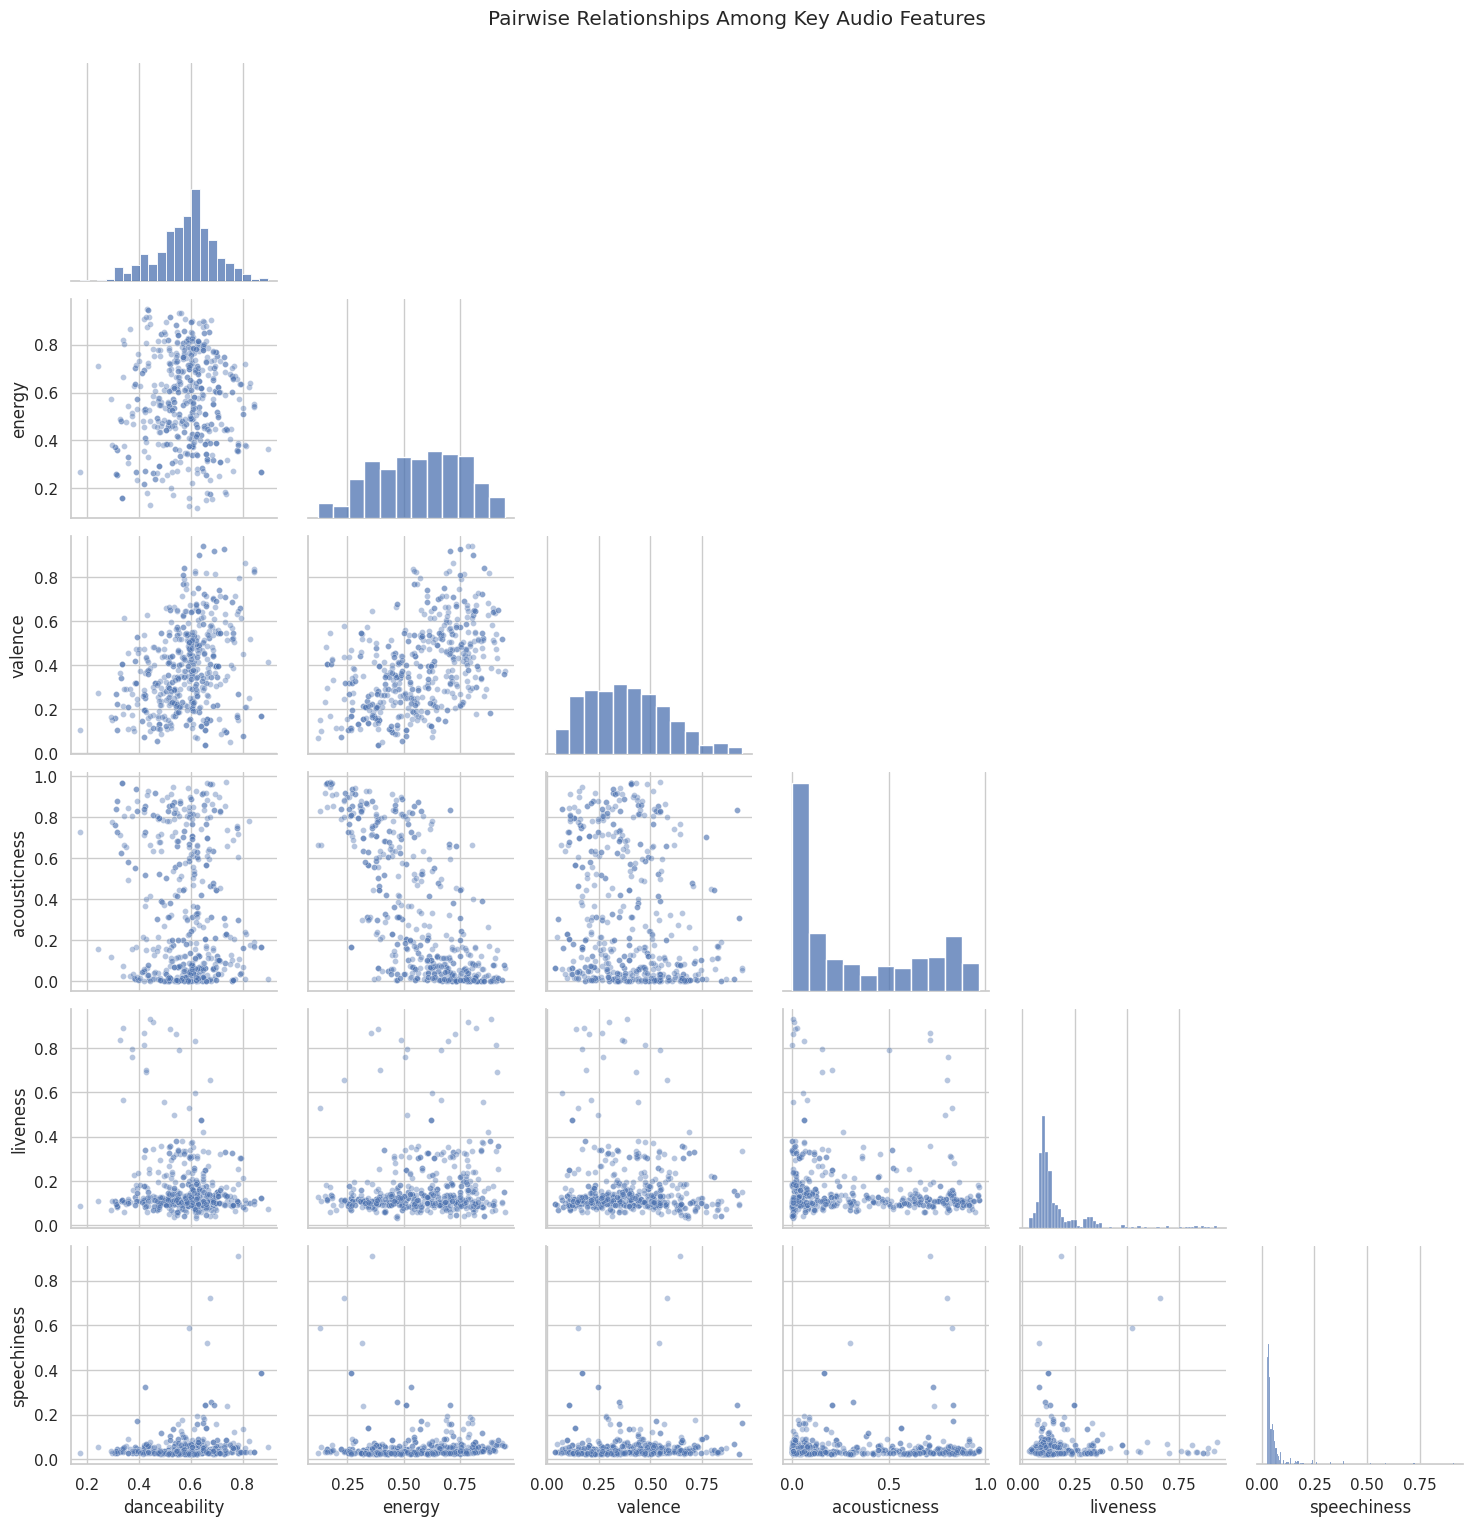

In [110]:
pair_feats = ["danceability", "energy", "valence", "acousticness", "liveness", "speechiness"]

sns.pairplot(
    df[pair_feats].dropna(),
    corner=True,          # only lower triangle
    diag_kind="hist",     # cleaner than KDE for speed
    plot_kws={"alpha": 0.4, "s": 18}
)

plt.suptitle("Pairwise Relationships Among Key Audio Features", y=1.02)
plt.show()

Pairwise plots reveal that while some audio features exhibit roughly linear relationships
(e.g., energy and danceability), others show non-linear patterns and clustering behavior.
Several features, such as speechiness and liveness, are highly skewed, with most songs
concentrated near low values.

These visual patterns suggest that Taylor Swift’s songs may group into distinct stylistic
profiles rather than varying along a single dimension, motivating the use of PCA and
clustering to uncover underlying structure in the data.

# PCA

In [111]:
# first fit PCA without choosing dimensions to see variance explained.

pca = PCA()
x_PCA = pca.fit_transform(x_scaled)

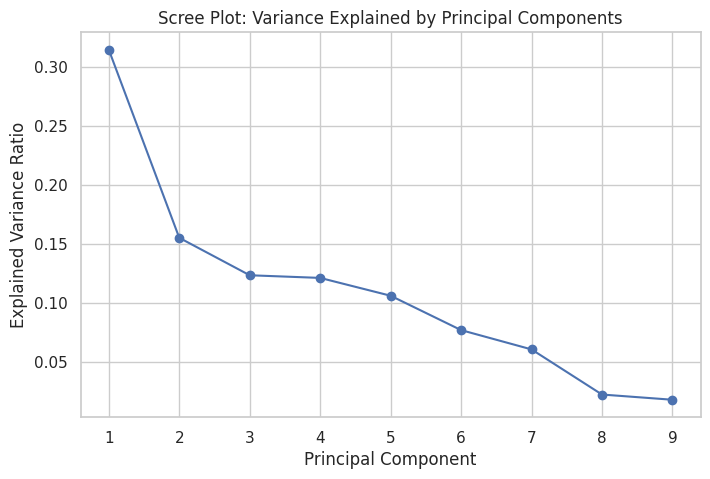

In [112]:
# scree plot

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_,
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot: Variance Explained by Principal Components")
plt.show()

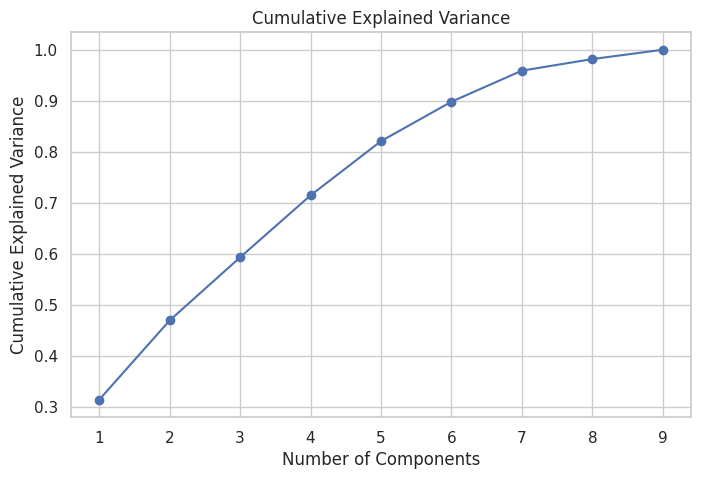

In [113]:
# cumulative variance plot, to determine how many features are needed

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.show()

The cumulative explained variance plot indicates an elbow around three principal
components, which together explain approximately 60% of total variance. This suggests
that the high-dimensional audio feature space can be effectively summarized using just 3 dimensions without excessive information loss.

In [114]:
# fit PCA with 3 components (for modeling)

pca_3 = PCA(n_components=3)
x_pca_3 = pca_3.fit_transform(x_scaled)

# create DataFrame for 3D PCA (used for clustering)
pca_df_3 = pd.DataFrame(
    x_pca_3,
    columns=["PC1", "PC2", "PC3"],
    index=x.index
)

While three components are kept for  analysis, a two-dimensional PCA projection is used for visualization.

In [115]:
# fit PCA with 2 components (for visualization)

pca_2 = PCA(n_components=2)
x_pca_2 = pca_2.fit_transform(x_scaled)

pca_df = pd.DataFrame(
    x_pca_2,
    columns=["PC1", "PC2"],
    index=x.index
)

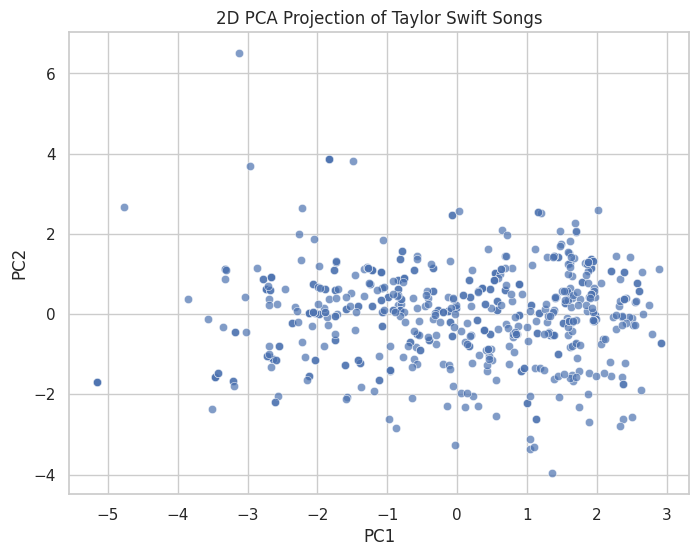

In [116]:
# plot 2D PCA projection

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, alpha=0.7)
plt.title("2D PCA Projection of Taylor Swift Songs")
plt.show()

While clear clusters are not immediately visible in this PCA projection, the structured way the songs are spread out suggests that underlying groupings may emerge once clustering methods are applied.

# Clustering

We will use the elbow method with K-means.

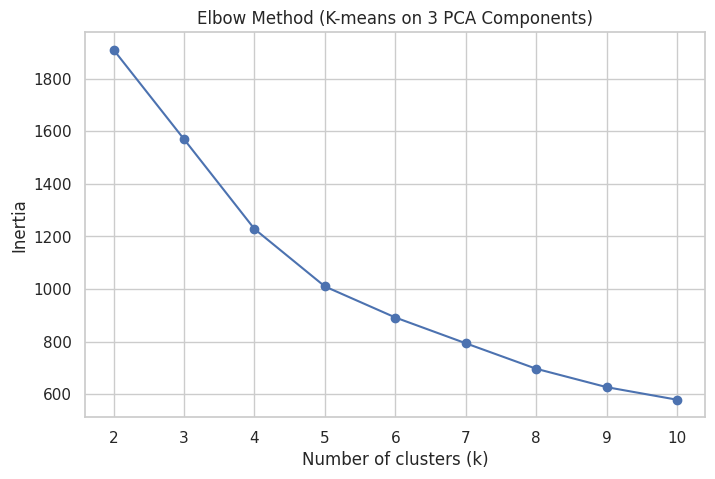

In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method using 3 PCA dimensions
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_df_3[["PC1", "PC2", "PC3"]])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (K-means on 3 PCA Components)")
plt.show()

Based on the elbow plot, I select k = 4, as inertia decreases sharply up to four clusters and flattens after, suggesting limited gains from additional clusters.

In [118]:
best_k = 4

In [119]:
# fit final K-means model

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_df_3["cluster"] = kmeans.fit_predict(pca_df_3[["PC1", "PC2", "PC3"]])

pca_df_3["cluster"].value_counts()

,count
cluster,
1,238
2,228
0,109
3,7


While k = 4 was selected based on the elbow method, one cluster contains a very small number of songs, suggesting the presence of outliers or highly experimental tracks. The remaining three clusters capture the dominant stylistic groupings in the data.

# Interpreting Clusters as Eras

In [120]:
# attach cluster labels to original dataset

df_clustered = x.copy()
df_clustered["cluster"] = pca_df_3["cluster"]

In [121]:
# compare average audio features by cluster

cluster_means = df_clustered.groupby("cluster").mean()
cluster_means

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness
cluster,,,,,,,,,
0,0.483908,0.669083,0.314953,0.148726,0.000179,0.301553,0.053672,145.619257,-5.917615
1,0.569866,0.397336,0.289597,0.624500,0.007679,0.115060,0.050260,117.035790,-10.071723
2,0.633009,0.701675,0.534605,0.113721,0.000560,0.139058,0.048924,117.771781,-5.812101
3,0.761143,0.262286,0.345429,0.449000,0.000010,0.259886,0.557429,93.886857,-13.146714


### Cluster 0: High-energy, mainstream pop

*   High energy
*   Fast tempo
*   Low acousticness
*   Moderately danceable
*   Emotionally neutral

This cluster represents big, polished pop tracks: loud, energetic songs built for radio and stadiums. Emotionally, they’re more neutral than sad or reflective, and they lean heavily on production rather than acoustic elements.

### Cluster 1: Acoustic/singer-songwriter

*   Very high acousticness
*   Lower energy
*   Slower tempo
*   Lower loudness

This cluster captures softer, acoustic-driven songs. These tracks feel more personal and restrained, emphasizing vocals and songwriting over production or intensity.

### Cluster 2: Upbeat, feel-good pop

*   High danceability
*   High energy
*   Highest valence (musical upbeatness)
*   Low acousticness

This cluster represents bright, upbeat, feel-good pop songs. They’re energetic, catchy, and emotionally positive — the most “fun” cluster in the dataset.

### Cluster 3: Experimental

*   Very small cluster
*   High speechiness
*   Lower energy
*   Slower tempo
*   Unusual combination of features

This small cluster likely captures outliers or stylistically experimental tracks that don’t fit neatly into her dominant sound patterns. These songs may experiment with spoken elements, unconventional structures, or atypical production choices.







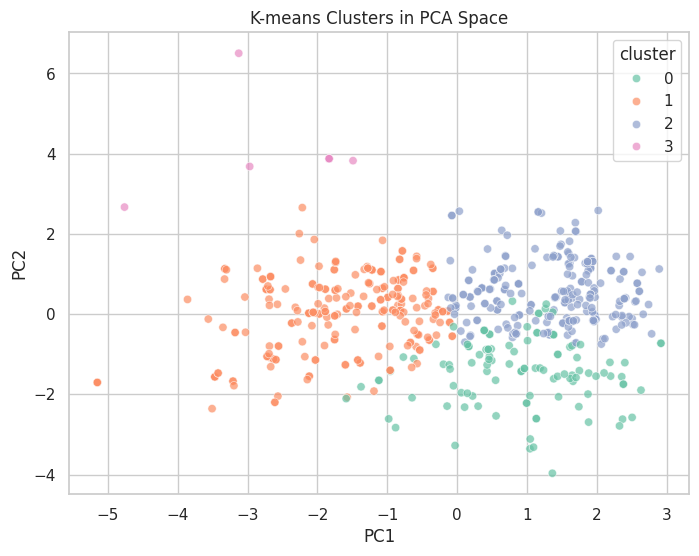

In [122]:
# plot clusters in PCA space

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="cluster",
    data=pca_df_3,
    palette="Set2",
    alpha=0.7
)
plt.title("K-means Clusters in PCA Space")
plt.show()

The figure shows the K-means clustering results projected onto the first two principal components for visualization. Although clustering was performed using three PCA dimensions, this two-dimensional view highlights how songs group together based on shared audio characteristics. The visible overlap between clusters suggests that changes in Taylor Swift’s sound are gradual rather than sharply defined.

To connect these stylistic groupings to artistic evolution, the next step examines how cluster membership shifts over time across her discography.

# Timeline: Sound Shifts Over Time

To understand how these stylistic clusters relate to Taylor Swift’s artistic evolution, I examine how cluster membership changes over time across her discography. This allows us to observe whether shifts in sound align with album eras or reflect more gradual transitions.

In [125]:
# rebuild df_clustered from original df

df_clustered = df.copy()
df_clustered["cluster"] = pca_df_3["cluster"]

df_clustered[["release_year", "cluster"]].head()

,release_year,cluster
0,2024,1
1,2024,1
2,2024,2
3,2024,1
4,2024,1


In [126]:
# distribution of clusters over time
timeline = (
    df_clustered
    .groupby(["release_year", "cluster"])
    .size()
    .reset_index(name="count")
)

timeline.head()

,release_year,cluster,count
0,2006,0,6
1,2006,1,3
2,2006,2,6
3,2008,0,14
4,2008,1,10


In [127]:
# convert counts to proportions within each year
timeline_pct = timeline.copy()
timeline_pct["total_songs_year"] = timeline_pct.groupby("release_year")["count"].transform("sum")
timeline_pct["pct"] = timeline_pct["count"] / timeline_pct["total_songs_year"]
timeline_pct.head()

,release_year,cluster,count,total_songs_year,pct
0,2006,0,6,15,0.400000
1,2006,1,3,15,0.200000
2,2006,2,6,15,0.400000
3,2008,0,14,43,0.325581
4,2008,1,10,43,0.232558


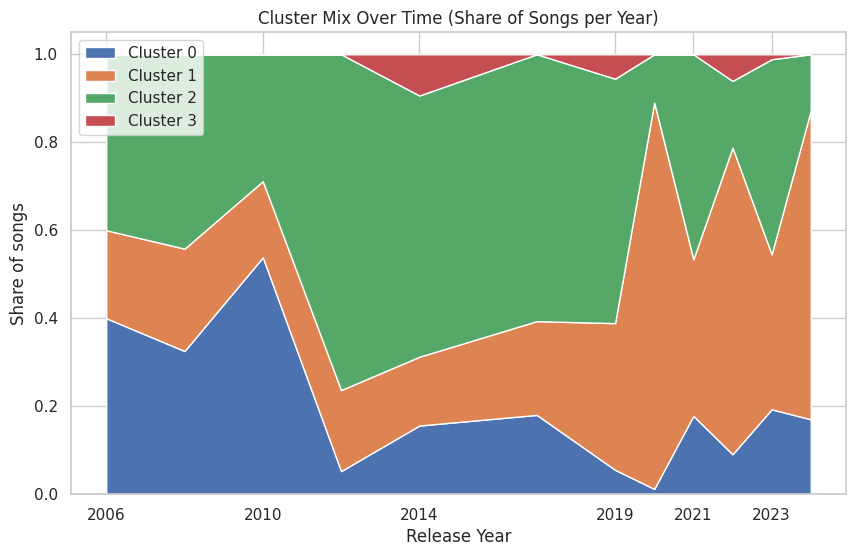

In [132]:
# pivot to wide for plotting
timeline_wide = timeline_pct.pivot(index="release_year", columns="cluster", values="pct").fillna(0)

plt.figure(figsize=(10,6))
plt.stackplot(
    timeline_wide.index,
    [timeline_wide[c] for c in timeline_wide.columns],
    labels=[f"Cluster {c}" for c in timeline_wide.columns]
)
plt.title("Cluster Mix Over Time (Share of Songs per Year)")
plt.xlabel("Release Year")
plt.ylabel("Share of songs")
plt.legend(loc="upper left")

years = timeline_wide.index
plt.xticks(years[::2])

plt.show()

In [133]:
# find dominant cluster in each release year

dominant_cluster = (
    timeline
    .sort_values(["release_year", "count"], ascending=[True, False])
    .groupby("release_year")
    .first()
    .reset_index()
)

dominant_cluster

,release_year,cluster,count
0,2006,0,6
1,2008,2,19
2,2010,0,28
3,2012,2,29
4,2014,2,19
5,2017,2,37
6,2019,2,10
7,2020,1,72
8,2021,2,34
9,2022,1,23


Identifying the dominant cluster each year reinforces the timeline results. Earlier releases show clearer dominance by a single cluster (cluster 2), while later years alternate between clusters more frequently, suggesting greater stylistic diversity rather than one consistently dominant sound.

# Findings & Implications

### Key Findings

**1.** **Taylor Swift’s sound evolves gradually rather than through abrupt shifts.**
Across both the PCA projection and the timeline analysis, clusters show overlap rather than sharp separation. This suggests that stylistic changes tend to emerge progressively, with new sounds layered onto existing ones instead of replacing them outright.

**2.** **Distinct stylistic groupings exist, but boundaries are fluid.**
While K-means clustering identifies four clusters based on audio features, these groups are not rigid genres. Songs often sit near cluster boundaries, reflecting hybrid characteristics and transitional phases in her discography.

**3.** **A sustained dominant sound emerges during the mid career period.**
From roughly 2012 through 2019, one cluster consistently dominates yearly releases. This indicates a prolonged stylistic phase, where core sonic traits remained stable across multiple albums rather than shifting dramatically between eras.

**4. Recent years show increased stylistic diversity.**
In later releases, dominance alternates more frequently between clusters. This suggests a move away from a single defining sound toward greater experimentation and coexistence of multiple styles within the same period.

**5. Outlier tracks highlight experimentation rather than noise.**
One cluster contains relatively few songs but persists across several years, indicating that these tracks are not random anomalies but represent intentional stylistic departures or highly experimental pieces.

# Limitations & Next Steps

### Limitations
This analysis relies exclusively on Spotify audio features, which capture production and sonic characteristics but do not account for lyrical content, themes, or cultural context.

K-means clustering requires selecting the number of clusters in advance; while the elbow method provides guidance, alternative choices of k could yield slightly different groupings.

PCA reduces high-dimensional data into fewer components, which may obscure subtler stylistic distinctions between songs.

Songs are treated independently, without accounting for album structure, track order, or collaborations.

### Next Steps
Incorporate lyrical features (e.g., sentiment, topic modeling) to examine how sonic and thematic evolution interact.

Compare clustering results across different algorithms to assess robustness.

Analyze transitions at the album level rather than the song level to better align with how artistic eras are typically defined.

Extend the approach to other artists to compare patterns of creative evolution across careers.